## GNSS Earthquake Early Warning Sensitivity Maps
## GeoRED Colombia
### Karime Escobar and David Mencin
### 2022

Earthquake early warning with GNSS is based on the real-time detection of the dynamic motion generated by an earthquake using GNSS derived position estimates, which do not saturate. Empirical relationships between distance and dynamic Peak Ground Displacement (**PGD**) have been developed as a way of rapidly estimating the magnitude of an earthquake (Melgar,2015:Crowell,2016,Ruhl,2019). PGD is the peak 2D or 3D ground motion of the dynamic motion generated by the earthquake.

$$ PGD_{2D} = \sqrt{ N^2 + E^2} $$
    
$$ PGD_{3D} = \sqrt{ N^2 + E^2 + U^2} $$
    
where:<br>
**N** = North deviation from a reference position.<br>
**E** = East deviation from a reference position.<br>
**U** = Vertical (Up) from a reference postion.

(PGD is simply the 2D L2-norm $||N^2+E^2||^2$ or 3D L2-norm $||N^2+E^2+U^2||^2$ of the deviation from a reference position.)
    
In order to determine the ability of a network to detect an earthquake we construct sensitivity maps. As an input for this sensitivity map we need:

- Station locations ($Latitude$,$Longitude$)
- Predicted or actual noise levels, $\sigma_{PGD}$, of the position estimates for the stations
- Magnitude, $M_{w}$, of the earthquake for the sensitiviy analysis

For each station location we determine the "detection" radius for the given magnitude and noise level. First we determine the detection threshold for each station based on the noise level. We define the base noise level as the standard deviation of the position esitmates, $\sigma_{PGD}$, for a sliding window (typcially two minutes) of the calcualted PGD estimates and then apply a simple detection threshold of a constant, $K$, times the noise level to determine the minimum dynamic motion that a particular station can detect.

$$ PGD_{min} = K * \sigma_{PGD} $$

we then calculate a detection radius for each station using the empirical formulas of (Melgar,2015:Crowell,2016,Ruhl,2019). The empirical relationships used are all based on a scaling law proposed by (Crowell, 2013):

$$ log(PGD) = A + B * M_{w} + C * M_{w} * Log(R) $$

where:<br>
**A**, **B** and **C** are empiricaly derived constants.<br>
$M_{w}$ is the magnitude of the earthquake.<br>
**R** is the hypocentral distance from the earthquake.

We solve R and substitute $PGD_{min}$ for PGD.

$$R = (\frac{log(PGD_{min} - A - B * M_{w}}{C * M_{w}})^{10} $$

where:<br>
**R** is now the detection radius for a given station.<br>
**A**, **B** and **C** are empiricaly derived constants.<br>
$M_{w}$ is the magnitude of the earthquake.

We then construct a **sensitivity heat map** by calculating the number of stations that would detect an earthquake of size, $M_{w}$, by counting the number of overlapping radii for all stations at a given location. Or stated another way, this overlap, or station detection denisty, represents the number of stations that would detect an earthquake of size, $M_{w}$, at that location. 

We further apply a constraint that a minimum number of stations, $min$, must detect the earthquake, i.e. we can't issue an early warning based on one station. We eliminate any location that does not meet this minimum threshold from the sensitvity map.

![overlay](overlay_image.png)


The final map looks similar to:

![sensitivity_map](Colombia_example.png)

***
**This rendered map represents the senstivity at any given location to an earthquake of size, $M{w}$, based on the detection threshold, $PGD_{min}$, of each station and the minimum number of stations, $min$, specified.**
***


***
**Translate above in Spanish.** (Karime)
***

In [2]:
#import required libraries, note you need the GMT package installed at
#the system level to support pygmt 
import pygmt
import numpy as np
import pandas as pd

Define some routines to calculate $PGD$ and $R$ based on $PGD_{min}$ and $M_{w}$.

In [15]:
def pgd(
        mag_w,
        distance_km,
        *,
        depth=0,
        method='Melgar2D_2015'):
    """
    pgd Calculates expected peak ground displacment based on hypo-central
    distance and Mw. PGD is defined as sqrt(x^2+y^2+z^2) for all methods
    except Melgar2D_2015, where it is sqrt(x^2+y^2).
    Distance units are in km.
    pgd is returned in cm.

    Parameters
    ----------
    :param mag_w: float
        Magnitude of earthquake
    :param distance_km: float or list of floats
        distance from earthquake, assumed to be epicentral distance unless a
        depth is supplied.
    :param depth: float
        optional
        depth of earthquake in km, depth positive, default is 0 km
    :param method: string
        optional
        method used for pgd calculation, can be
        Melgar2D_2015 (default)
        Melgar3D_2015
        Crowell_2016
        Ruhl_2019 (Do not use...)
    :return:
        float or list of floats (if distance is supplied as an list), output is in cm.

    UNAVCO 2020-2022 (Mencin)
    """
    distance = np.array(distance_km)

    if method == 'Melgar2D_2015':
        a = -4.639
        b = 1.063
        c = -0.137
    elif method == 'Melgar3D_2015':
        a = -4.434
        b = 1.047
        c = -0.138
    elif method == 'Crowell_2016':
        a = -6.687
        b = 1.500
        c = -0.214
    elif method == 'Ruhl_2019':
        a = -5.919
        b = 1.009
        c = -0.145
        distance_km = distance_km*1000
    else:
        sys.exit("Invalid method, use: Melgar2D_2015 (default), Melgar3D_2015, Crowell_2016 or Ruhl_2019.")

    log_pgd = a + b * mag_w + c * mag_w * np.log10(np.sqrt(np.power(distance, 2) + np.power(depth, 2)))
    peak_ground_displacement_mm = np.float_power(10, log_pgd)

    if method == 'Ruhl_2019':
        peak_ground_displacement_mm = peak_ground_displacement_mm * 100
    else:
        peak_ground_displacement_mm = peak_ground_displacement_mm

    return peak_ground_displacement_mm

In [16]:
def get_distance_from_mw(
                        mag_w,
                        *,
                        pgd_threshold=1.0,
                        method='Melgar2D_2015'):
    """
    get_distance_from_mw Calculates distance that given peak ground displacement would occur, based on
    hypo-central distance and Mw. PGD is defined as sqrt(x^2+y^2+z^2) for all methods except Melgar2D_2015,
    where it is sqrt(x^2+y^2).
    pgd units in cm.
    Distance units are in km.


    :param mag_w:
        Magnitude of earthquake
    :param pgd_threshold:
        expected pgd (cm).
    :param method:
        optional
        method used for pgd calculation, can be
        Melgar2D_2015 (default)
        Melgar3D_2015
        Crowell_2016
        Ruhl_2019
    :return:
        distance (km) that expected pgd (cm) would occur.

    UNAVCO 2020 (Mencin, based on Hodgkinson)
    """

    if method == 'Melgar2D_2015':
        a = -4.639
        b = 1.063
        c = -0.137
    elif method == 'Melgar3D_2015':
        a = -4.434
        b = 1.047
        c = -0.138
    elif method == 'Crowell_2016':
        a = -6.687
        b = 1.500
        c = -0.214
    elif method == 'Ruhl_2019':
        a = -5.919
        b = 1.009
        c = -0.145
        # This method uses meters
        pgd_threshold=pgd_threshold*.01
    else:
        sys.exit("Invalid method, use: Melgar2D_2015 (default), Melgar3D_2015, Crowell_2016 or Ruhl_2019.")

    radius = np.power(10, (np.log(pgd_threshold) - a - b * mag_w) / (c * mag_w))

    return radius

Build sensitivity maps based on $Lon$, $K$, $Lat$, $PGD_{min}$, and $M_{w}$

In [17]:
# define the map (study) extents
min_lon = -79
max_lon = -66
min_lat = 2
max_lat = 14

In [18]:
# Define K and MW
k = 1.5
Mw = 7.0
min_station = 5

In [19]:
gmt_input_filename = 'temp_colombia.csv'
station_input_filename = '2022-01-19-cGNSS-Colombia-Noise.csv'
heatmap_filename = "heat_map_colombia.nc"

In [20]:
# read in the topograpy for generating background map
grid = pygmt.datasets.load_earth_relief(region=[min_lon,max_lon,min_lat,max_lat],resolution='15s')

In [21]:
# Read in station locations and noise for each station
df = pd.read_csv (station_input_filename)

In [22]:
df['distance'] = get_distance_from_mw(Mw, pgd_threshold=k*df.noise)

In [23]:
# Here we need to write out the locations and detection thresholds for use 
# in parts of GMT that were not included in pyGMT
header=["lon","lat","distance"]
df.to_csv(gmt_input_filename, columns = header, header = False, index = False)

In [24]:
# Call external zsh script to deal with the fact that parts of GMT
# were not included in pyGMT, it's possible that this could be done
# within geoPandas, but there was no easy way
# look into this for "production" but for the paper it's fine.
extent = "{}/{}/{}/{}".format(min_lon,max_lon,min_lat,max_lat)
!./make_heat_map.zsh {extent} {heatmap_filename} {gmt_input_filename} {min_station}

Processing -73.722322,4.637935,119.17735061708703 ...
Processing -75.291762,2.955823,119.17735061708703 ...
Processing -75.465981,3.724927,119.17735061708703 ...
Processing -74.791405,10.879539,119.17735061708703 ...
Processing -75.954155,4.766397,119.17735061708703 ...
Processing -74.138787,4.688431,119.17735061708703 ...
Processing -75.562136,1.588917,119.17735061708703 ...
Processing -74.057577,4.809657,119.17735061708703 ...
Processing -74.435776,9.262967,119.17735061708703 ...
Processing -75.742123,4.812911,119.17735061708703 ...
Processing -76.382448,3.532836,119.17735061708703 ...
Processing -75.641113,3.200175,119.17735061708703 ...
Processing -74.230935,11.112528,119.17735061708703 ...
Processing -74.18935,10.584904,119.17735061708703 ...
Processing -73.373702,5.519885,119.17735061708703 ...
Processing -74.884549,5.21041,119.17735061708703 ...
Processing -72.917756,11.527985,119.17735061708703 ...
Processing -76.870139,3.534662,119.17735061708703 ...
Processing -71.406906,7.02

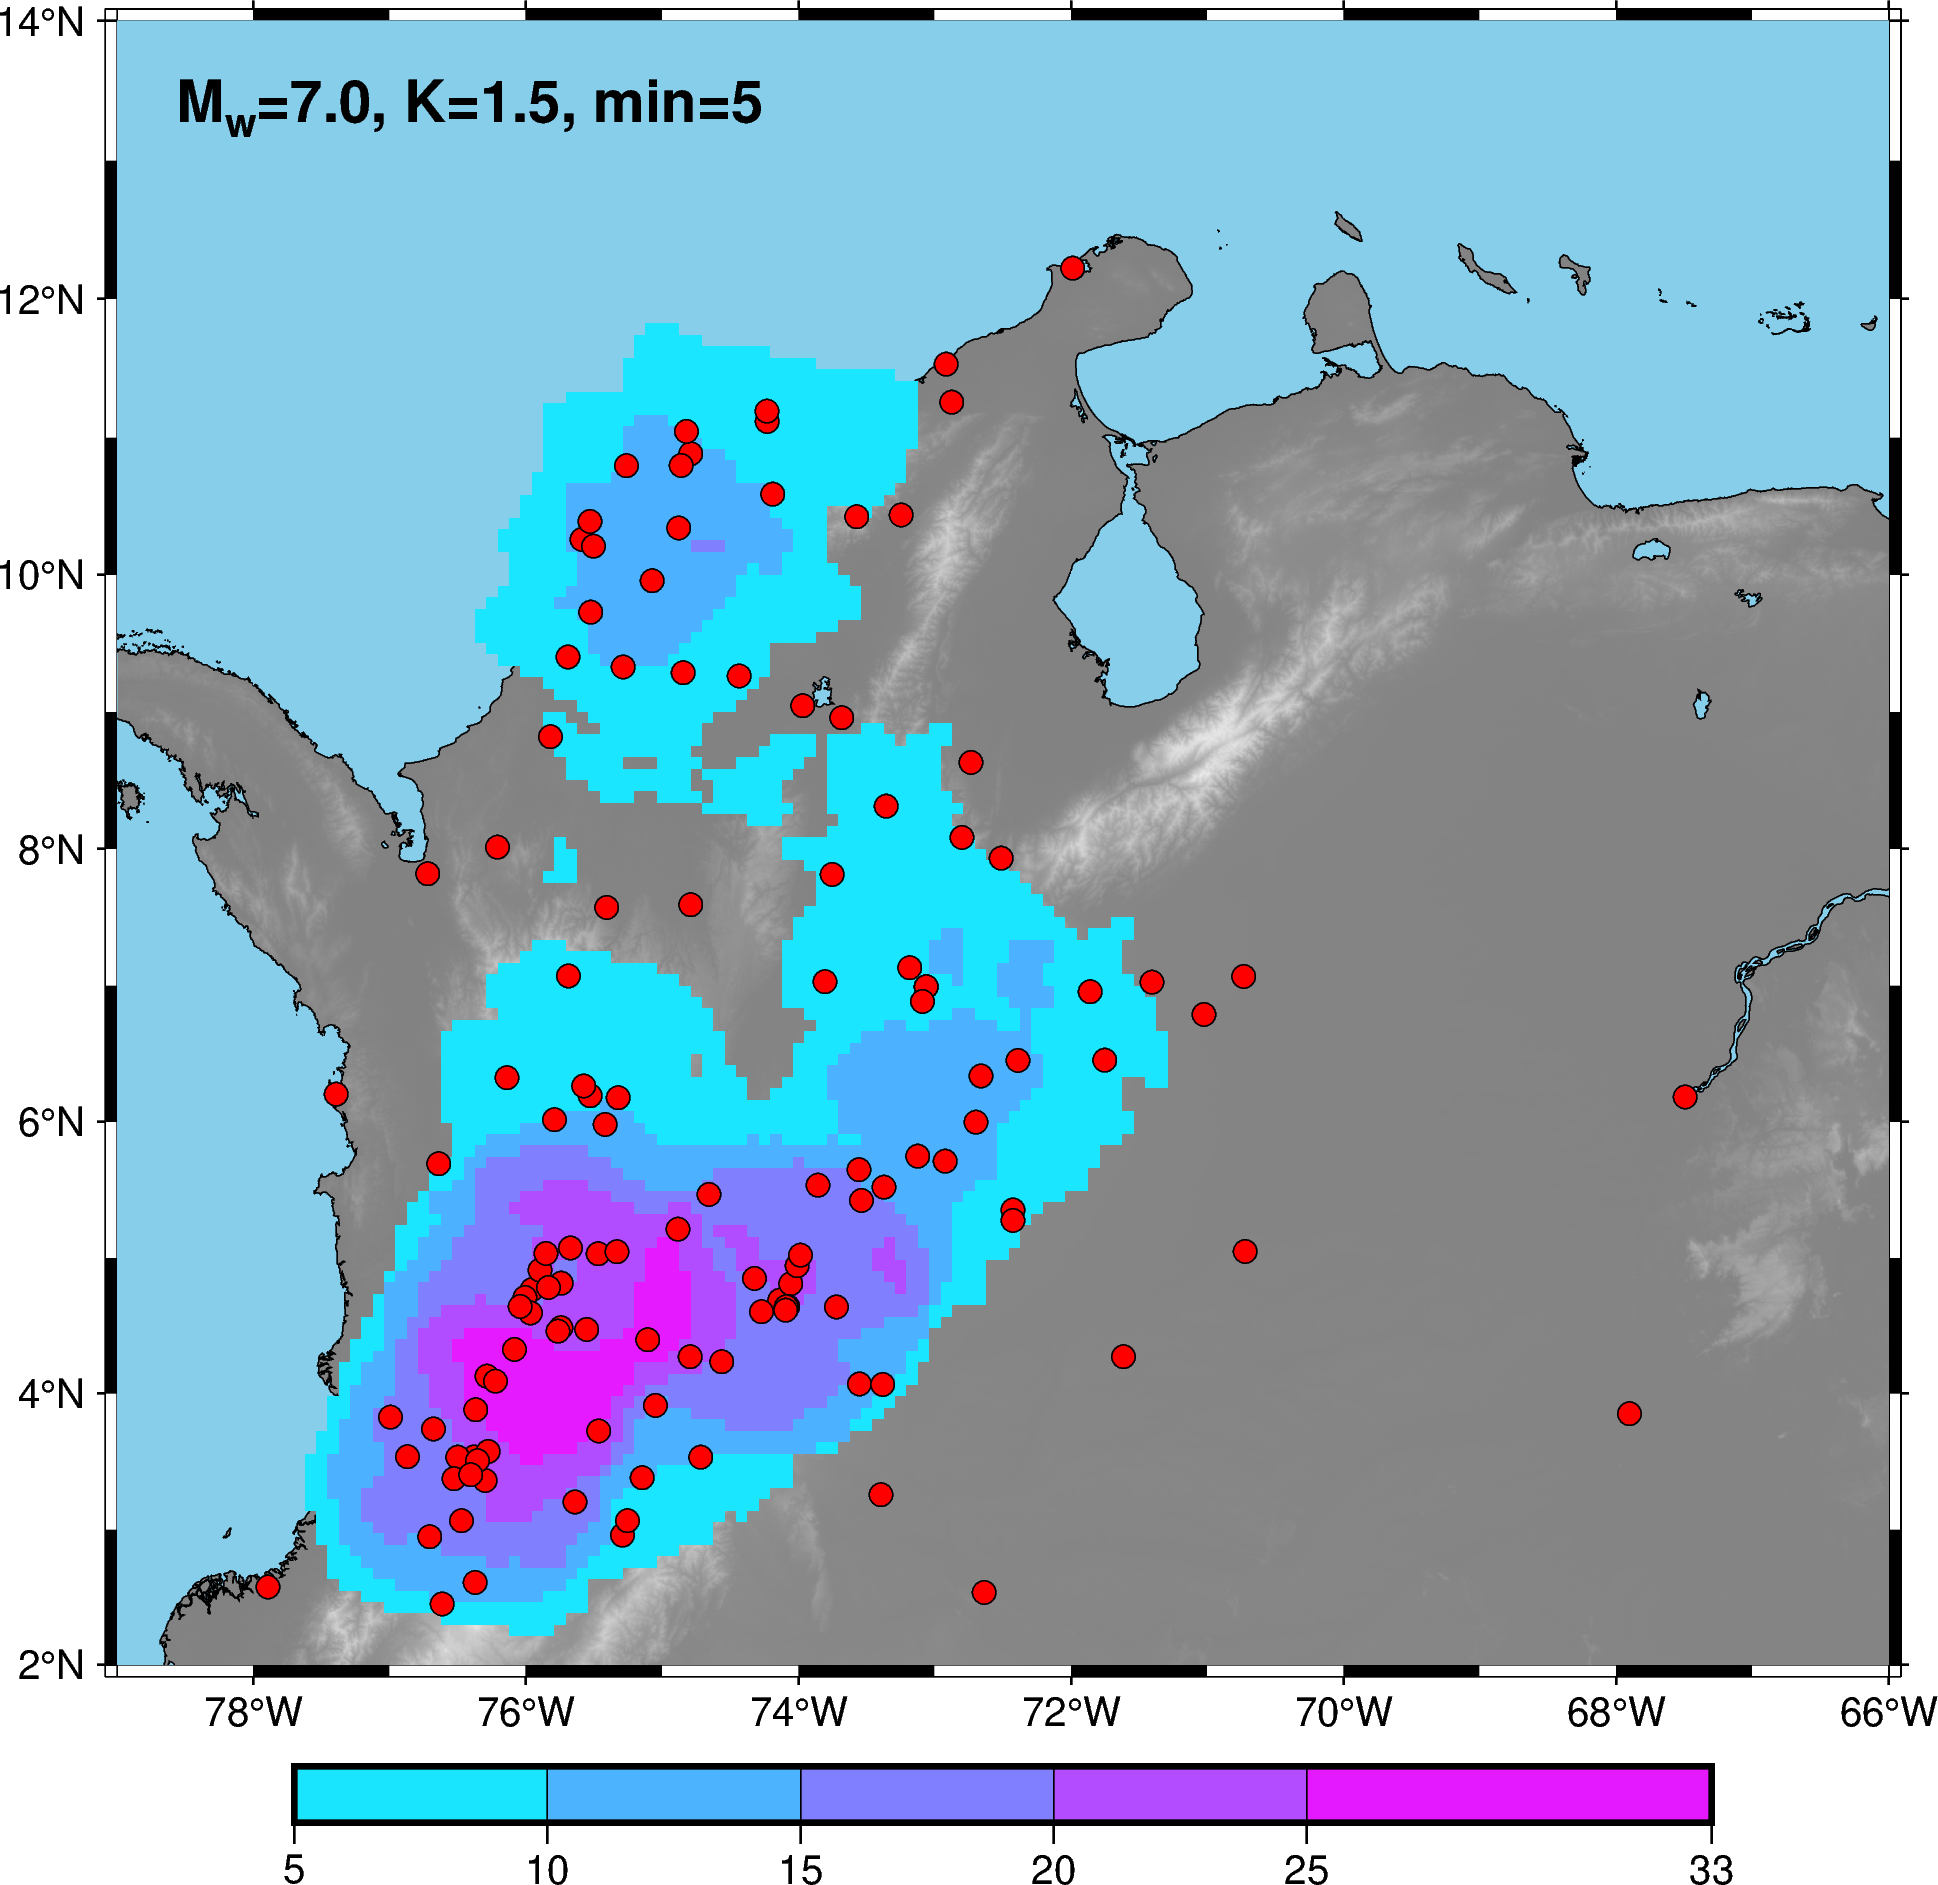

In [25]:
# Build figure using pyGMT
projection = "M-71.5/8/15c"
label= "M@-w@-=" + "{:.1f}".format(Mw) + ", K=" + "{:.1f}".format(k) + ", min=" + "{:.0f}".format(min_station)
fig = pygmt.Figure()
fig.basemap(projection=projection, region=[min_lon,max_lon,min_lat,max_lat], frame=True)
fig.grdimage(grid=grid,cmap="gray")
fig.coast(shorelines=True, water="skyblue")
color=pygmt.grd2cpt(grid='heat_map_colombia.nc',cmap="cool", series=[min_station,5*min_station,5],no_bg=True)
fig.grdimage(grid='heat_map_colombia.nc',cmap=color,transparency=0,nan_transparent=True)
fig.plot(x=df.lon, y=df.lat, style="c0.2c", color="red", pen="black")
fig.text(text=label, position="LT", offset=".5c/-.5c", font="14p,Helvetica-Bold,black")
#fig2.grdcontour(grid='heat_map.nc')
fig.colorbar()
fig.show()

The colobar represents the number of staions that would detect a given earthquake given:  $Lon$, $K$, $Lat$, $PGD_{min}$, and $M_{w}$

In [14]:
# If you want to save this in a different format
save_filename="Colombia_M"+"{:.1f}".format(Mw)+"_K="+"{:.1f}".format(k)+"_min="+"{:.0f}".format(min_station)+".pdf"
fig.savefig(save_filename)